# Tutorial

Start by downloading the astrometry data to the local working folder:

In [1]:
!wget https://raw.githubusercontent.com/wbalmer/backtracks/main/tests/scorpions1b_orbitizelike.csv

--2024-01-03 15:07:35--  https://raw.githubusercontent.com/wbalmer/backtracks/main/tests/scorpions1b_orbitizelike.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 831 [text/plain]
Saving to: ‘scorpions1b_orbitizelike.csv’

scorpions1b_orbitiz 100%[===================>]     831  --.-KB/s    in 0s      

2024-01-03 15:07:35 (22.0 MB/s) - ‘scorpions1b_orbitizelike.csv’ saved [831/831]



Then, import the `System` class from the `backtracks` package.

In [2]:
from backtracks import System

Now, we can set up the `System` class. We'll provide it with: 
- the Simbad resolvable name of our host star of interest `target_name=[your star's name]`
- a .csv file containing the relative positions of our candidate source around our host star (`candidate_file=[your .csv file here`, see the example .csv for an example)
- a range in degrees around which we'll construct a local sample of proper motions and parallaxes from _Gaia_ (`nearby_window=0.5`, the default is 0.5 degrees, which is fine for most cases)
- a path to a directory to save our figures and intermediate data products (`fileprefix=[your/path/here/]`)

In [3]:
track = System(target_name="HD 131399A",
               candidate_file="scorpions1b_orbitizelike.csv",
               nearby_window=0.5,
               fileprefix='./')

[BACKTRACK INFO]: Resolved the target star 'HD 131399A' in Simbad!
[BACKTRACK INFO]: Resolved target's Gaia ID from Simbad, Gaia DR3 6204835284262018688
INFO: Query finished. [astroquery.utils.tap.core]
[BACKTRACK INFO]: gathered Gaia DR3 data for HD 131399A
   * Gaia source ID = 6204835284262018688
   * Reference epoch = 2016.0
   * RA = 223.6053 deg
   * Dec = -34.1429 deg
   * PM RA = -30.70 mas/yr
   * PM Dec = -30.77 mas/yr
   * Parallax = 9.75 mas
   * RV = 15.61 km/s
INFO: Query finished. [astroquery.utils.tap.core]
[BACKTRACK INFO]: gathered 6445 Gaia objects from the 0.5 sq. deg. nearby HD 131399A
[BACKTRACK INFO]: Finished nearby background gaia statistics
[BACKTRACK INFO]: Queried distance prior parameters, L=2524.23, alpha=1.05, beta=0.62
[BACKTRACK INFO]: Estimating candidate position if stationary in RA,Dec @ 2016.0 from observation #0
[BACKTRACK INFO]: Opened ephemeris file


The `backtracks.System` class queries Simbad, then _Gaia_ and retrieves both the _Gaia_ parameters for the host star and the distribution of parameters for all the stars nearby (this is useful for quantifying whether your candidate's motion is an outlier in terms of velocity or distance). It then sets up the stationary, infinite distance background object case, and compares the data to this track. Let's take a look at that visually:

[BACKTRACK INFO]: Generating Stationary plot
[BACKTRACK INFO]: Stationary plot saved to ./


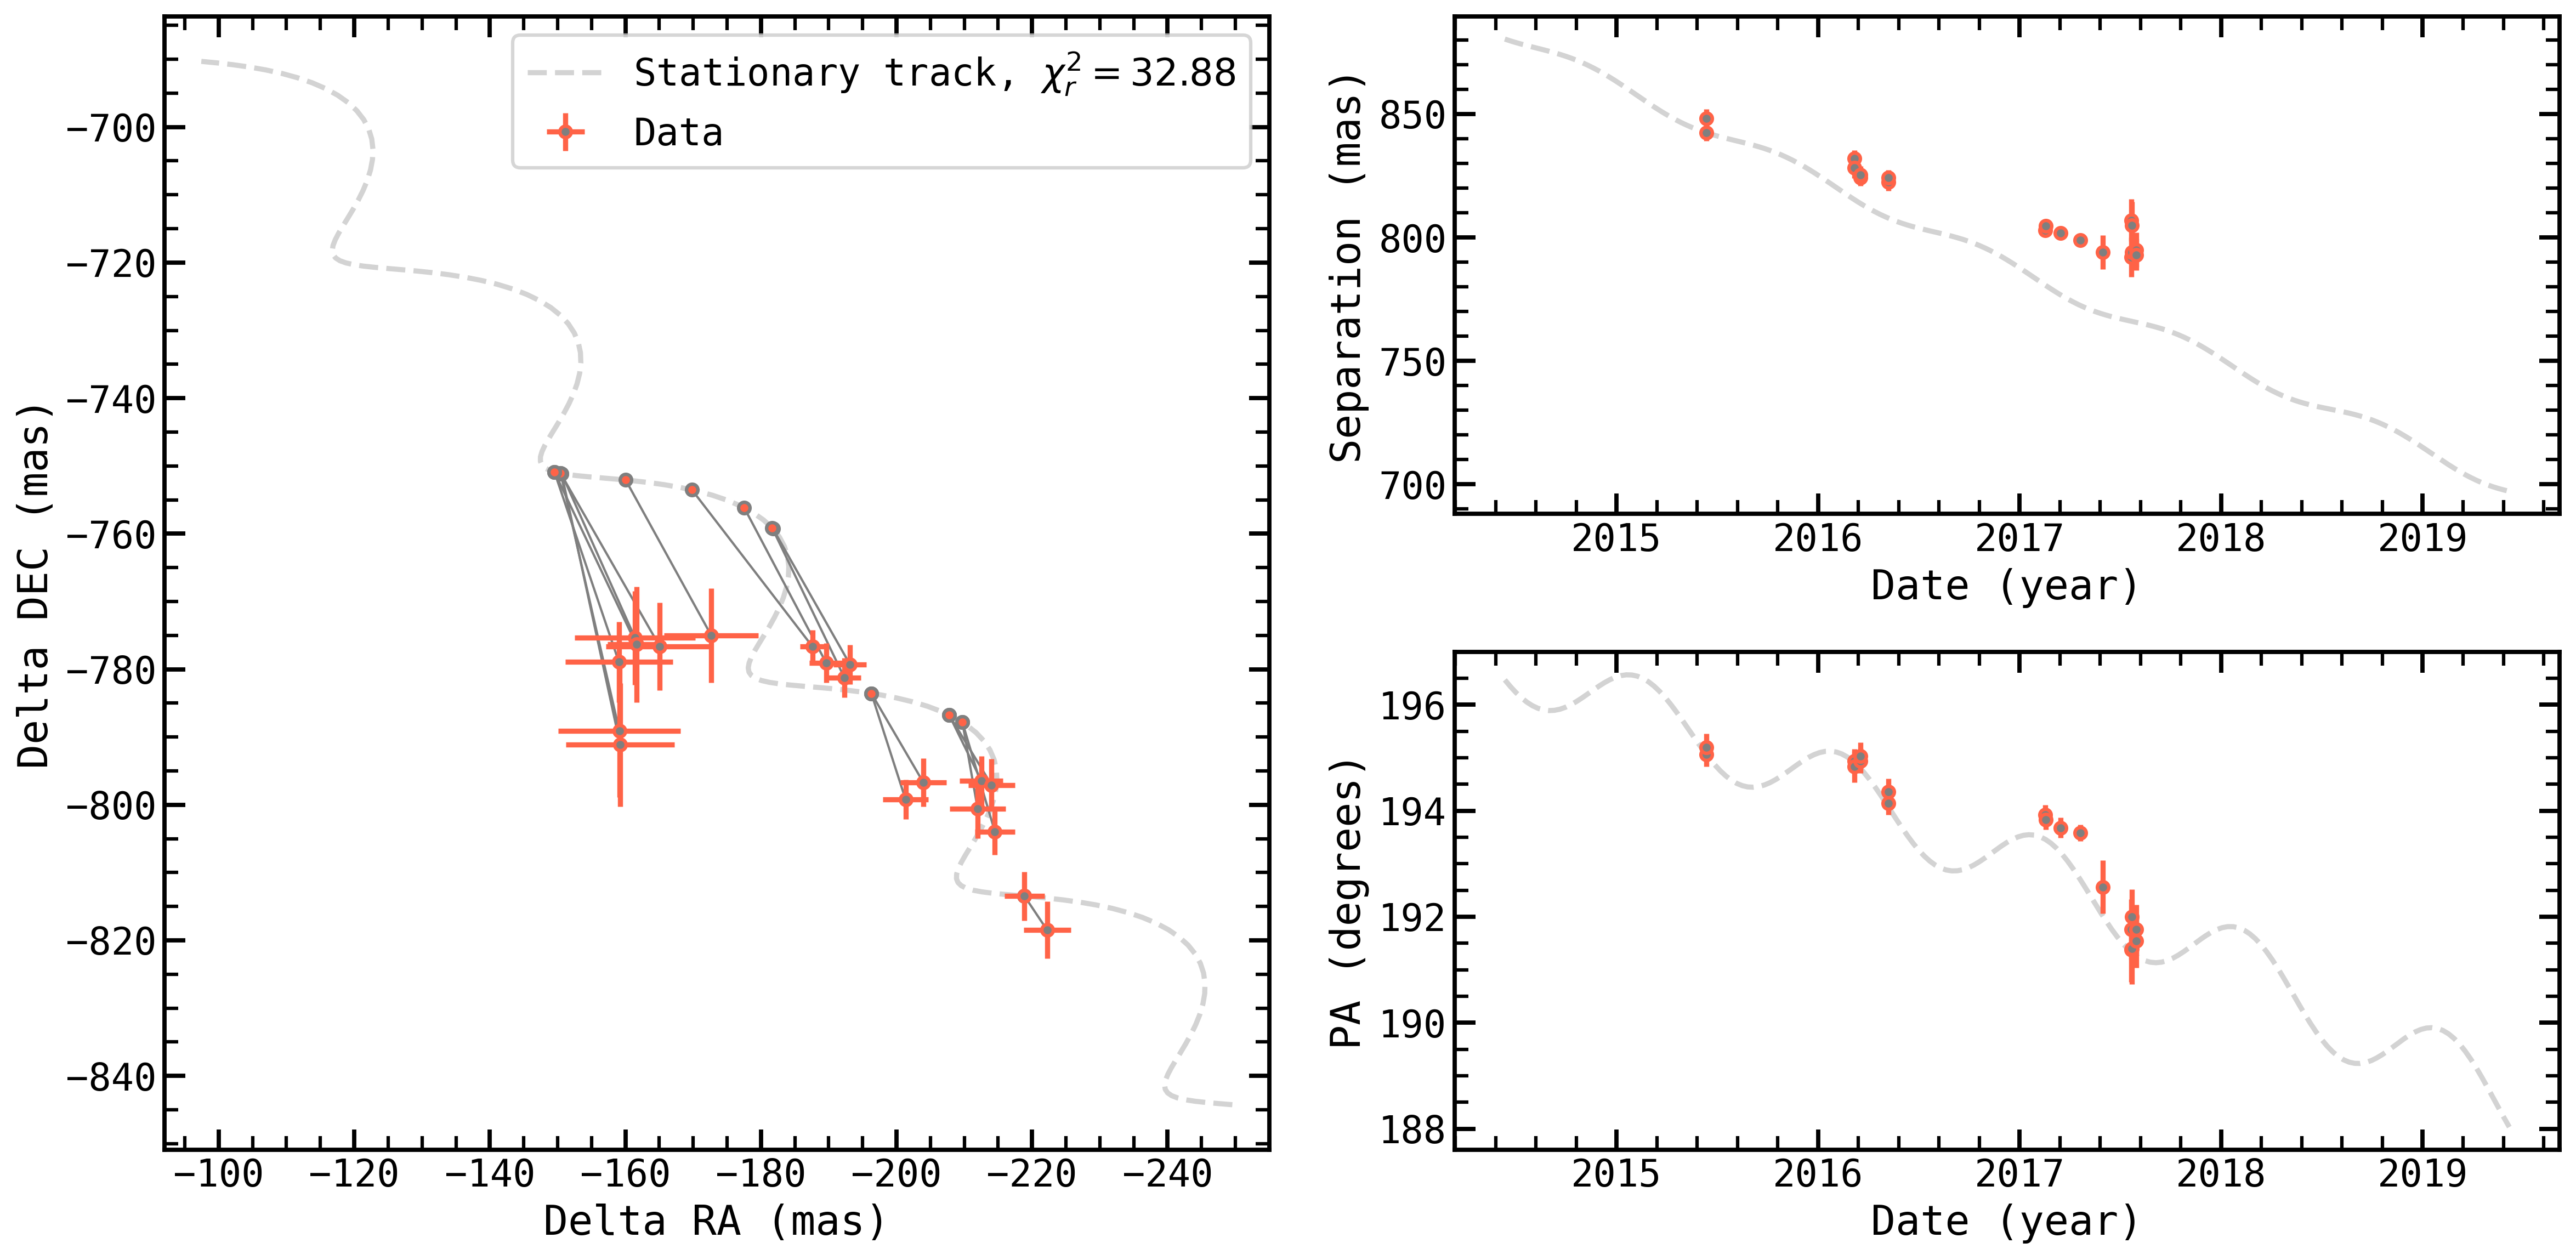

In [4]:
fig_stationary = track.generate_stationary_plot(days_backward=1.*365.,
                                                days_forward=4.*365,
                                                step_size=10.,
                                                filepost='.png')

It looks like the stationary, infinite distance case is a pretty poor fit to this data. Does that mean these are observations of a planet?! Unfortunately, no. The fit is poor, but the data and this helical motion share some visual similarities that might prompt us to consider continuing to use `backtracks` to investigate.

We can set up and run a `fit` that will use the nested sampling package `dynesty` to explore varying the proper motion and parallax of a background star, and compare this apparent helical motion to our data.

`fit` takes a number of parameters, not all of which you might care about at the start. You can set any combination of these parameters to:
- sample more coarsely (lower nlive), or more finely (increase nlive)
- speed up convergence but sacrifice precision (increase dlogz, e.g. to 1 or 10). 
- use more cpu cores (set npool higher)
- sample the posterior fully (set dynamic=True) but note that this can take a while!
- run on a cluster with mpi_pool = True
- resume from a previous run
- or, depending on your case, to speed up convergence on a different dataset,
- use a different sampling method (e.g. 'rwalk' or 'rslice') 

Let's run a coarse, initial fit that will terminate rather early to get a handle on the results of `backtracks`. For a more accurate assessment, we'd recommend you set `dlogz=0.1` and `nlive=500`, and we'd recommend exploring dynamic sampling to flesh out your posterior distribution with `dynamic=True`. Note that if your data is _not_ well described by helical background track motion, these fits will struggle to converge, so we recommend you always start by comparing your data to the stationary case, and run a coarse, easily terminated inital run before spending computation time on a full `fit`. 

In [5]:
results = track.fit(dlogz=10, npool=4, dynamic=False, nlive=200, mpi_pool=False, resume=False, sample_method='unif')

[BACKTRACK INFO]: Beginning sampling


iter: 3968 | +200 | bound: 56 | nc: 1 | ncall: 24082 | eff(%): 17.452 | loglstar:   -inf < -100.702 <    inf | logz: -123.627 +/-  0.467 | dlogz:  0.108 > 10.000                                     

We'll save our results to disk, so that we can access them without re-running the sampler:

In [6]:
track.save_results(fileprefix='./')

[BACKTRACK INFO]: Saving results to ./HD_131399A_dynestyrun_results.pkl


And we can load those results (initializing the `track` object with the `System` class in the same way as above):

In [7]:
track.load_results(fileprefix='./')

[BACKTRACK INFO]: Loading results from ./HD_131399A_dynestyrun_results.pkl


You can then plot the results of your `fit` using the functions in `backtracks.plotting`. We have two convenience functions within the `System` class to generate these plots with a single line of code (the first of which we used above to generate the stationary track plot). We'll generate a plot of the visual helix, a plot of the posterior distribution of parameters, a plot of diagnostics for the `dynesty` sampler run, a plot showing the prior on parallax we've assumed, and a plot of our median sample compared to the distribution of nearby _Gaia_ measurements.

[BACKTRACK INFO]: Generating Plots


/Users/wbalmer/backtracks/backtracks/plotting.py:47: RuntimeWarning: divide by zero encountered in divide
  ppf = 1000./transform_gengamm(u, backtracks.L, backtracks.alpha, backtracks.beta)


[BACKTRACK INFO]: Plots saved to ./


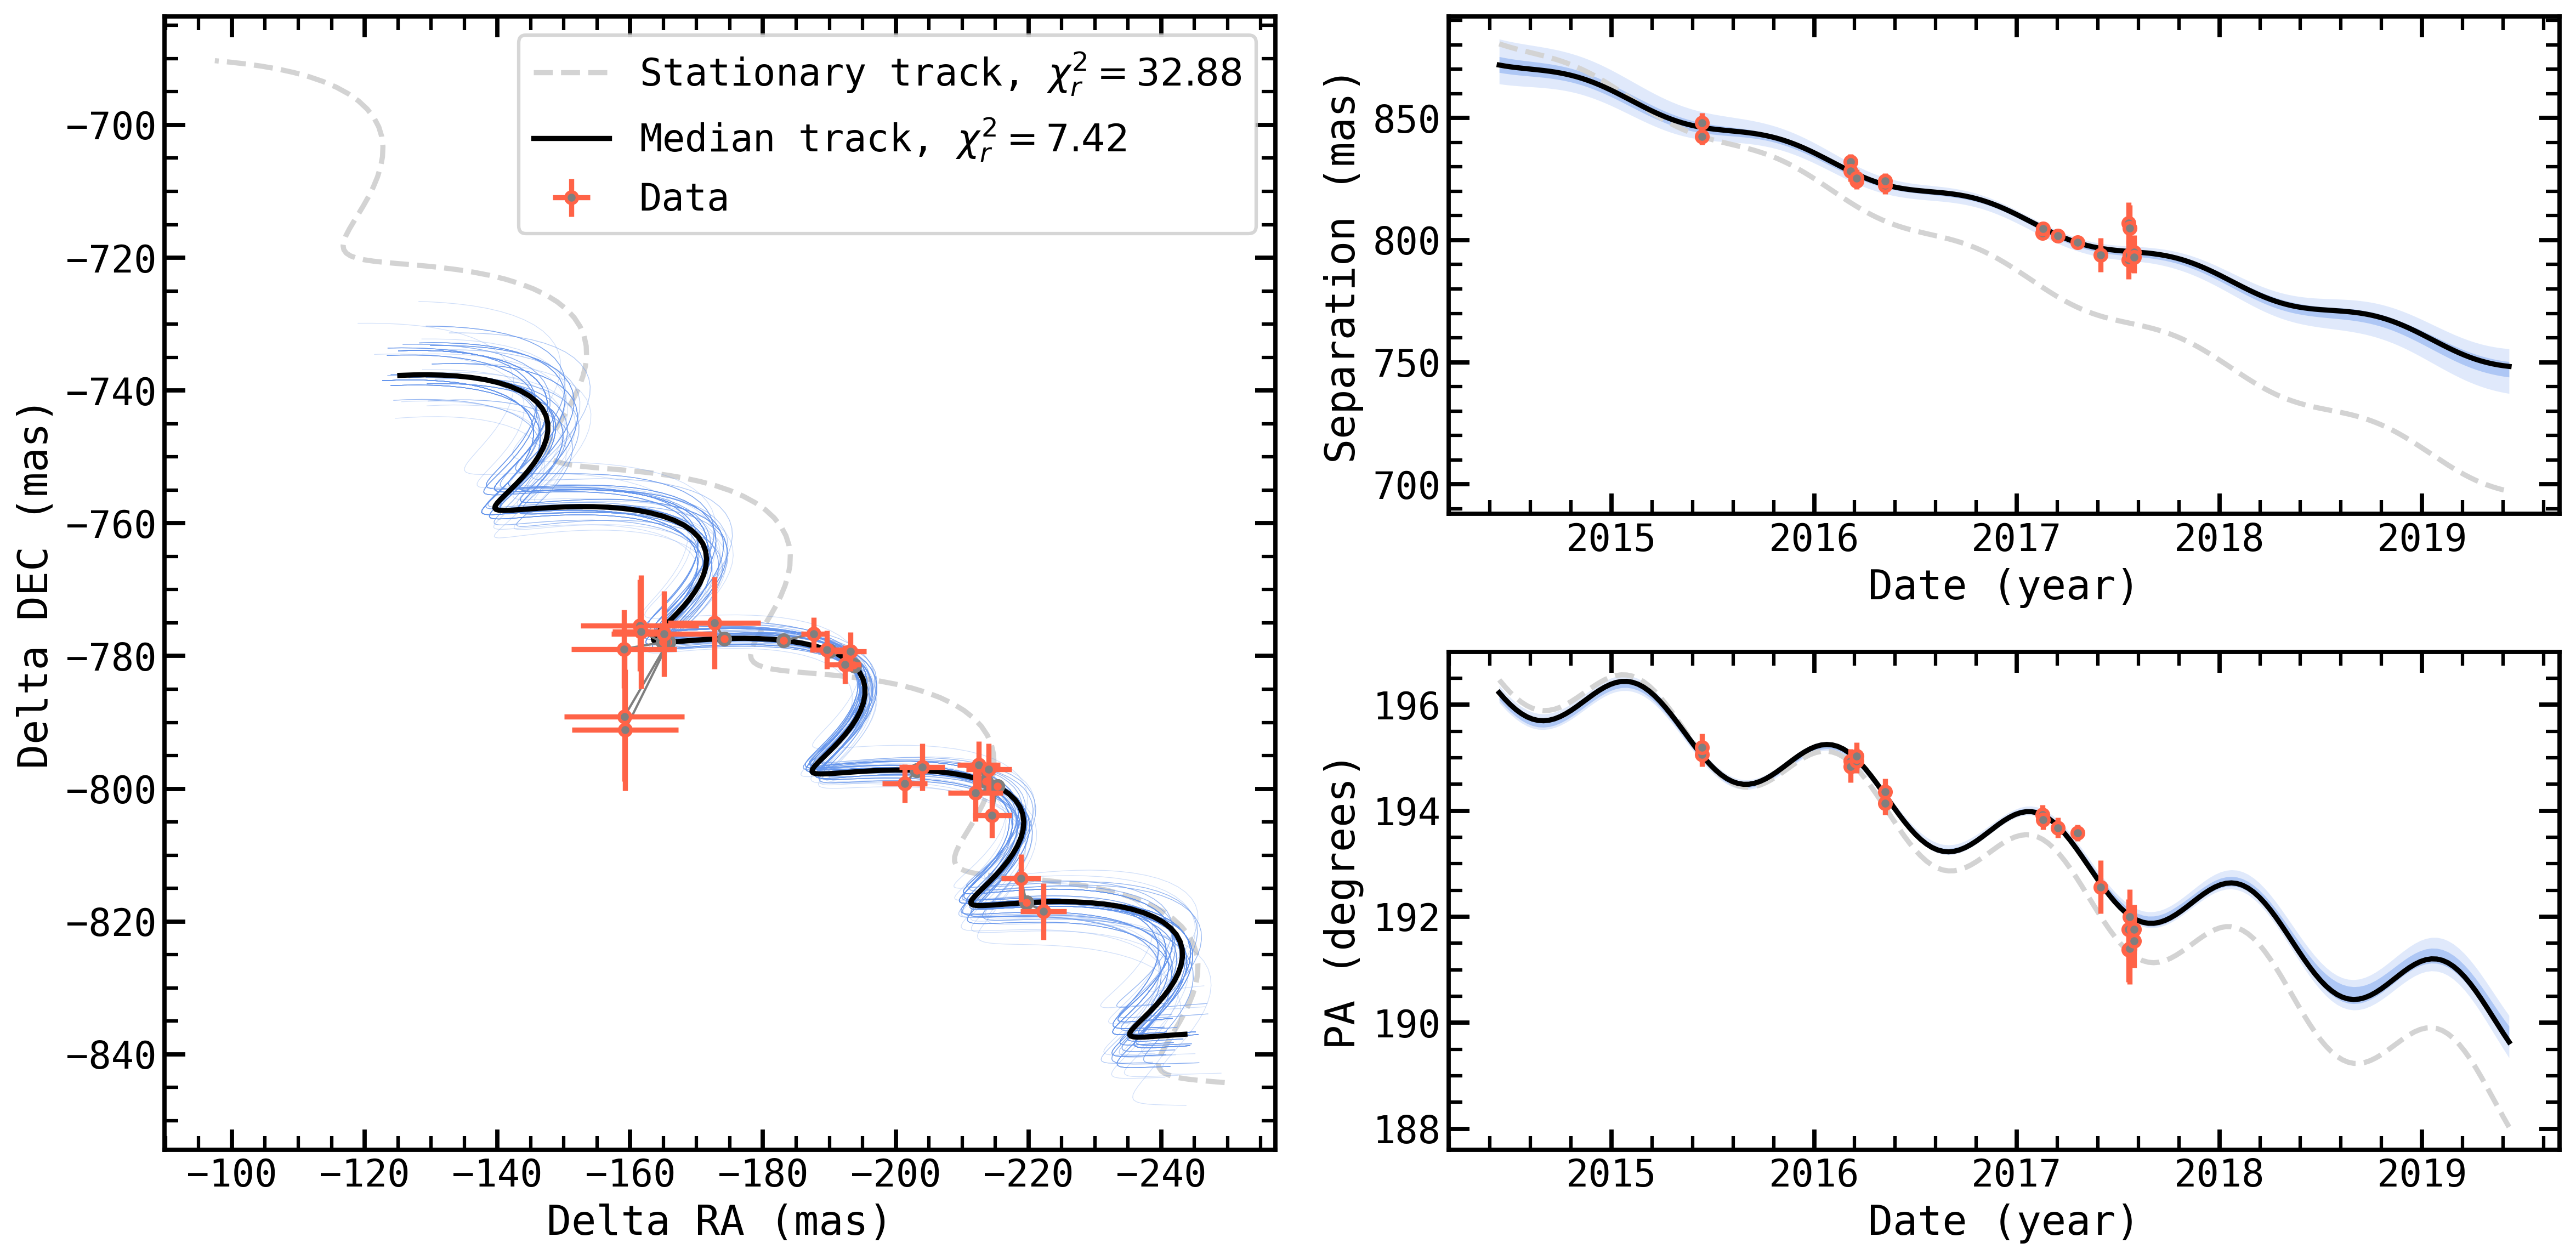

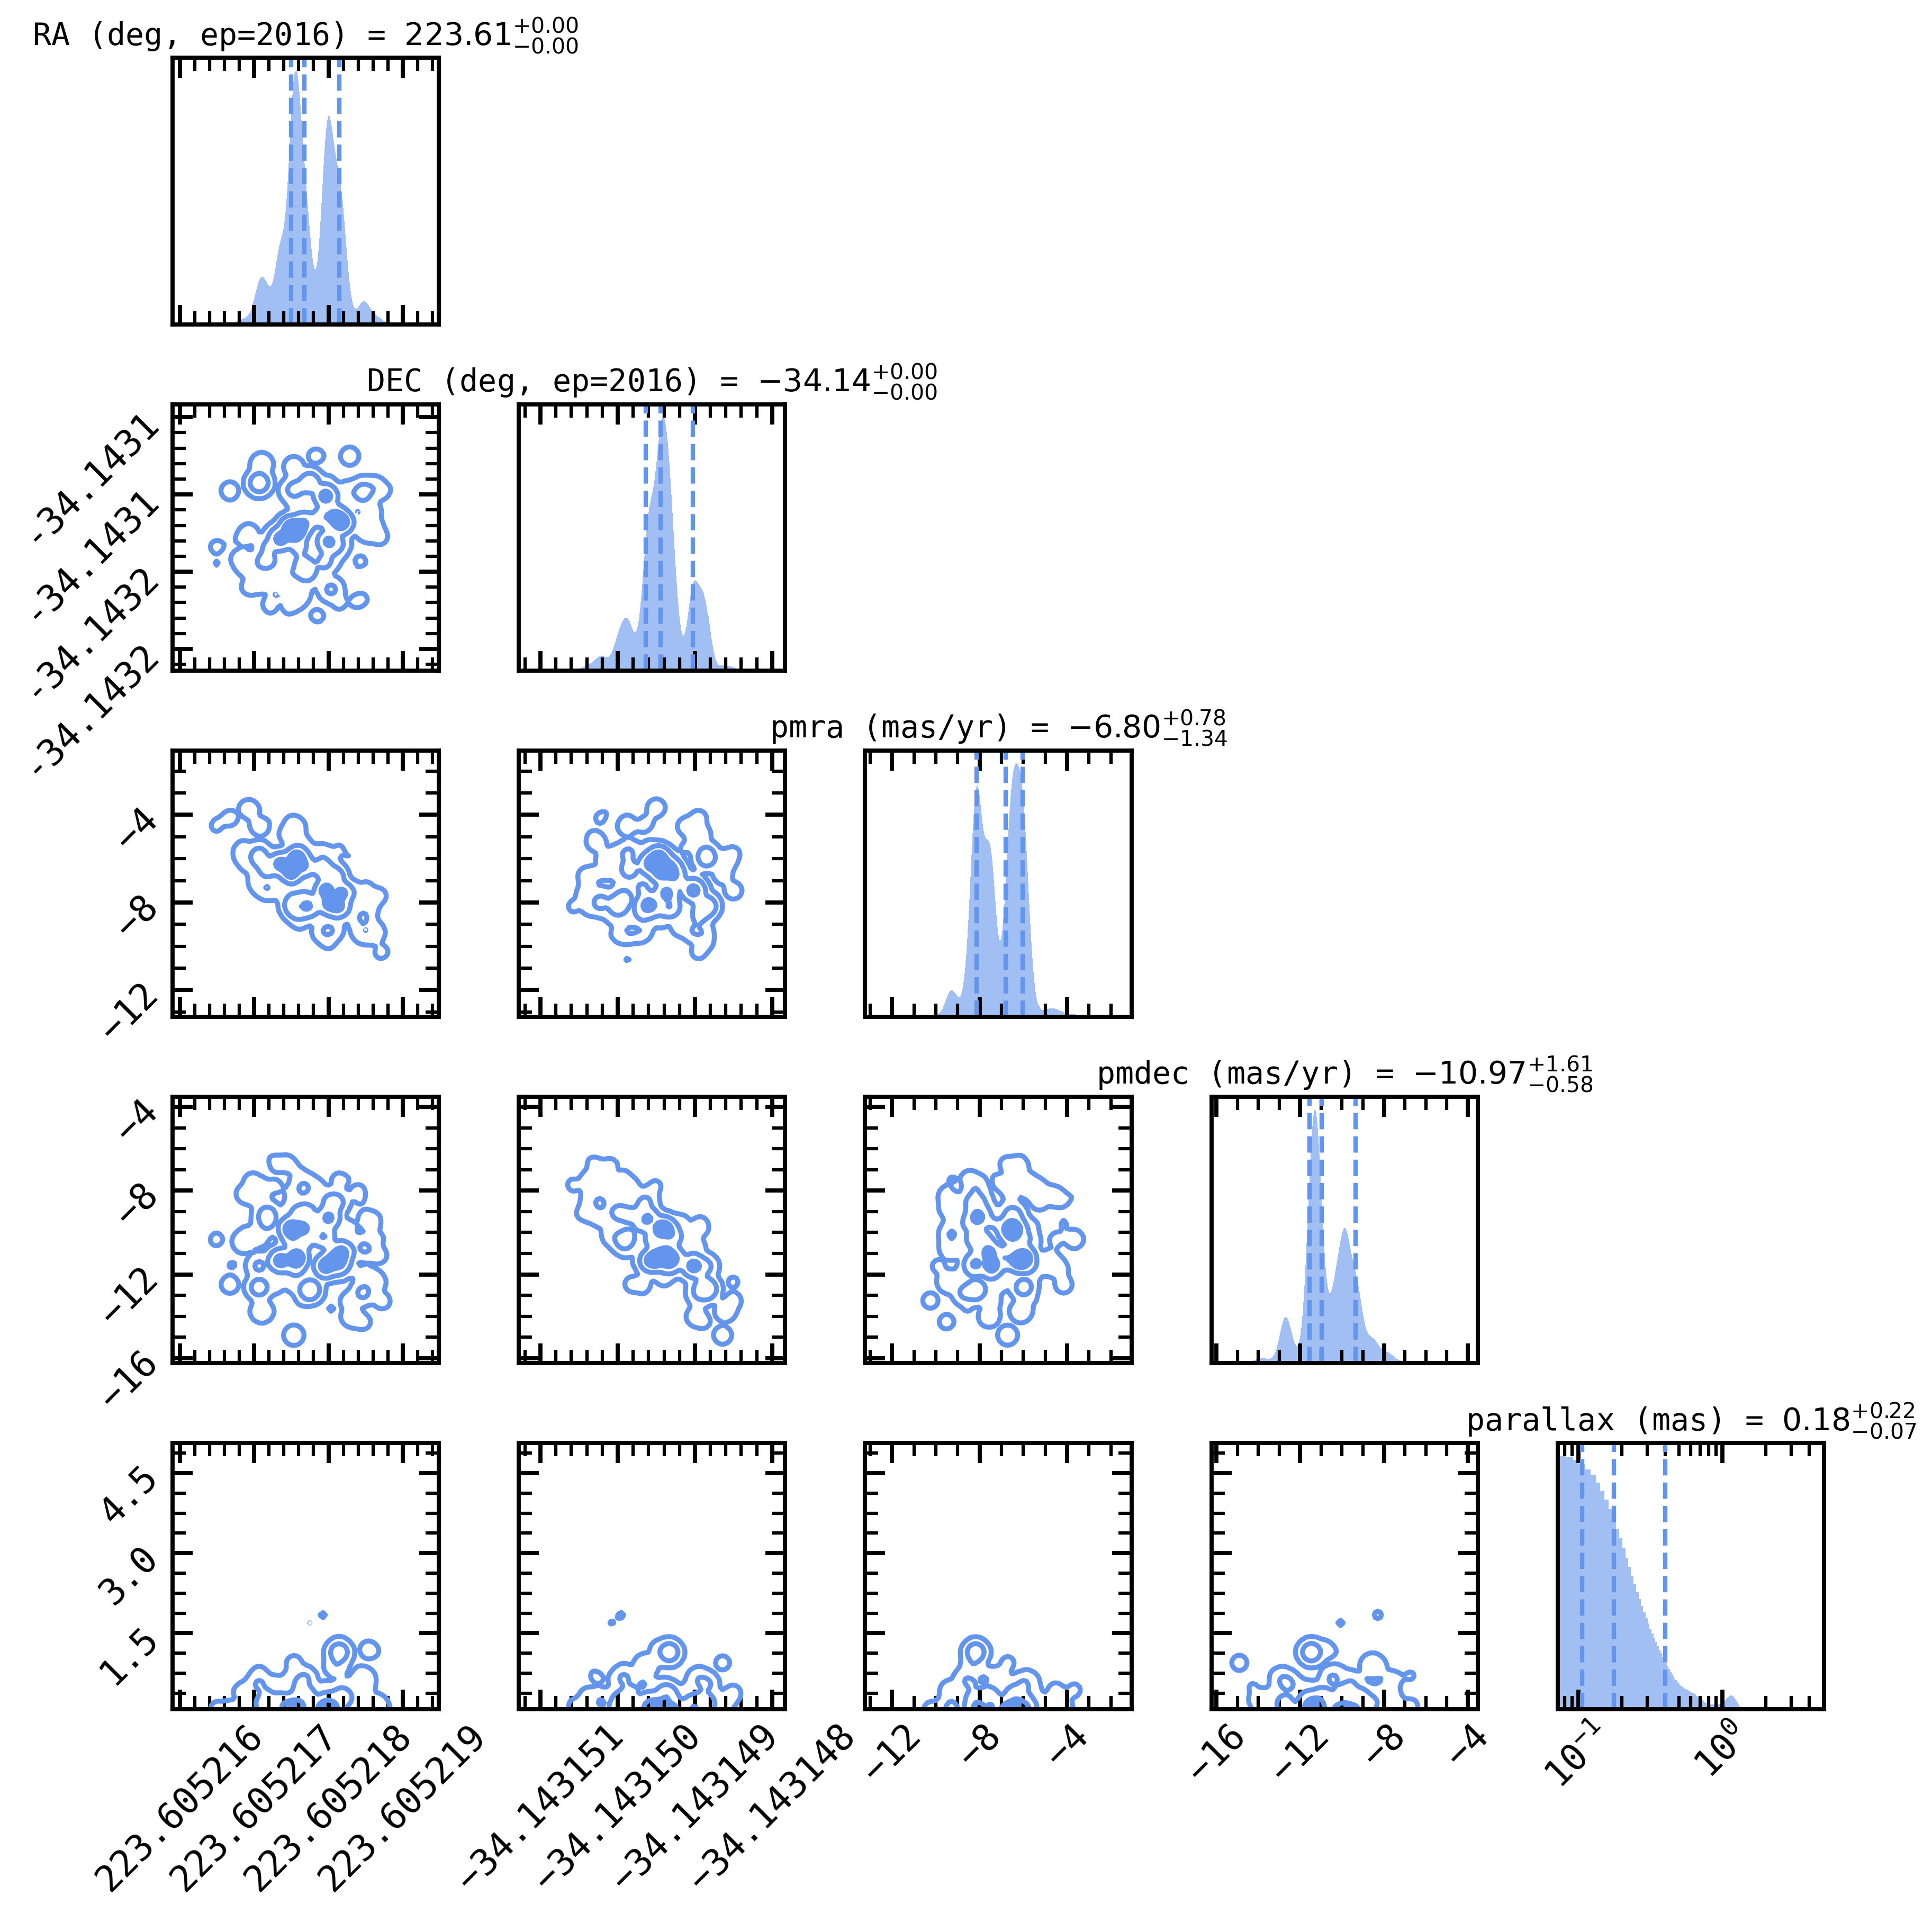

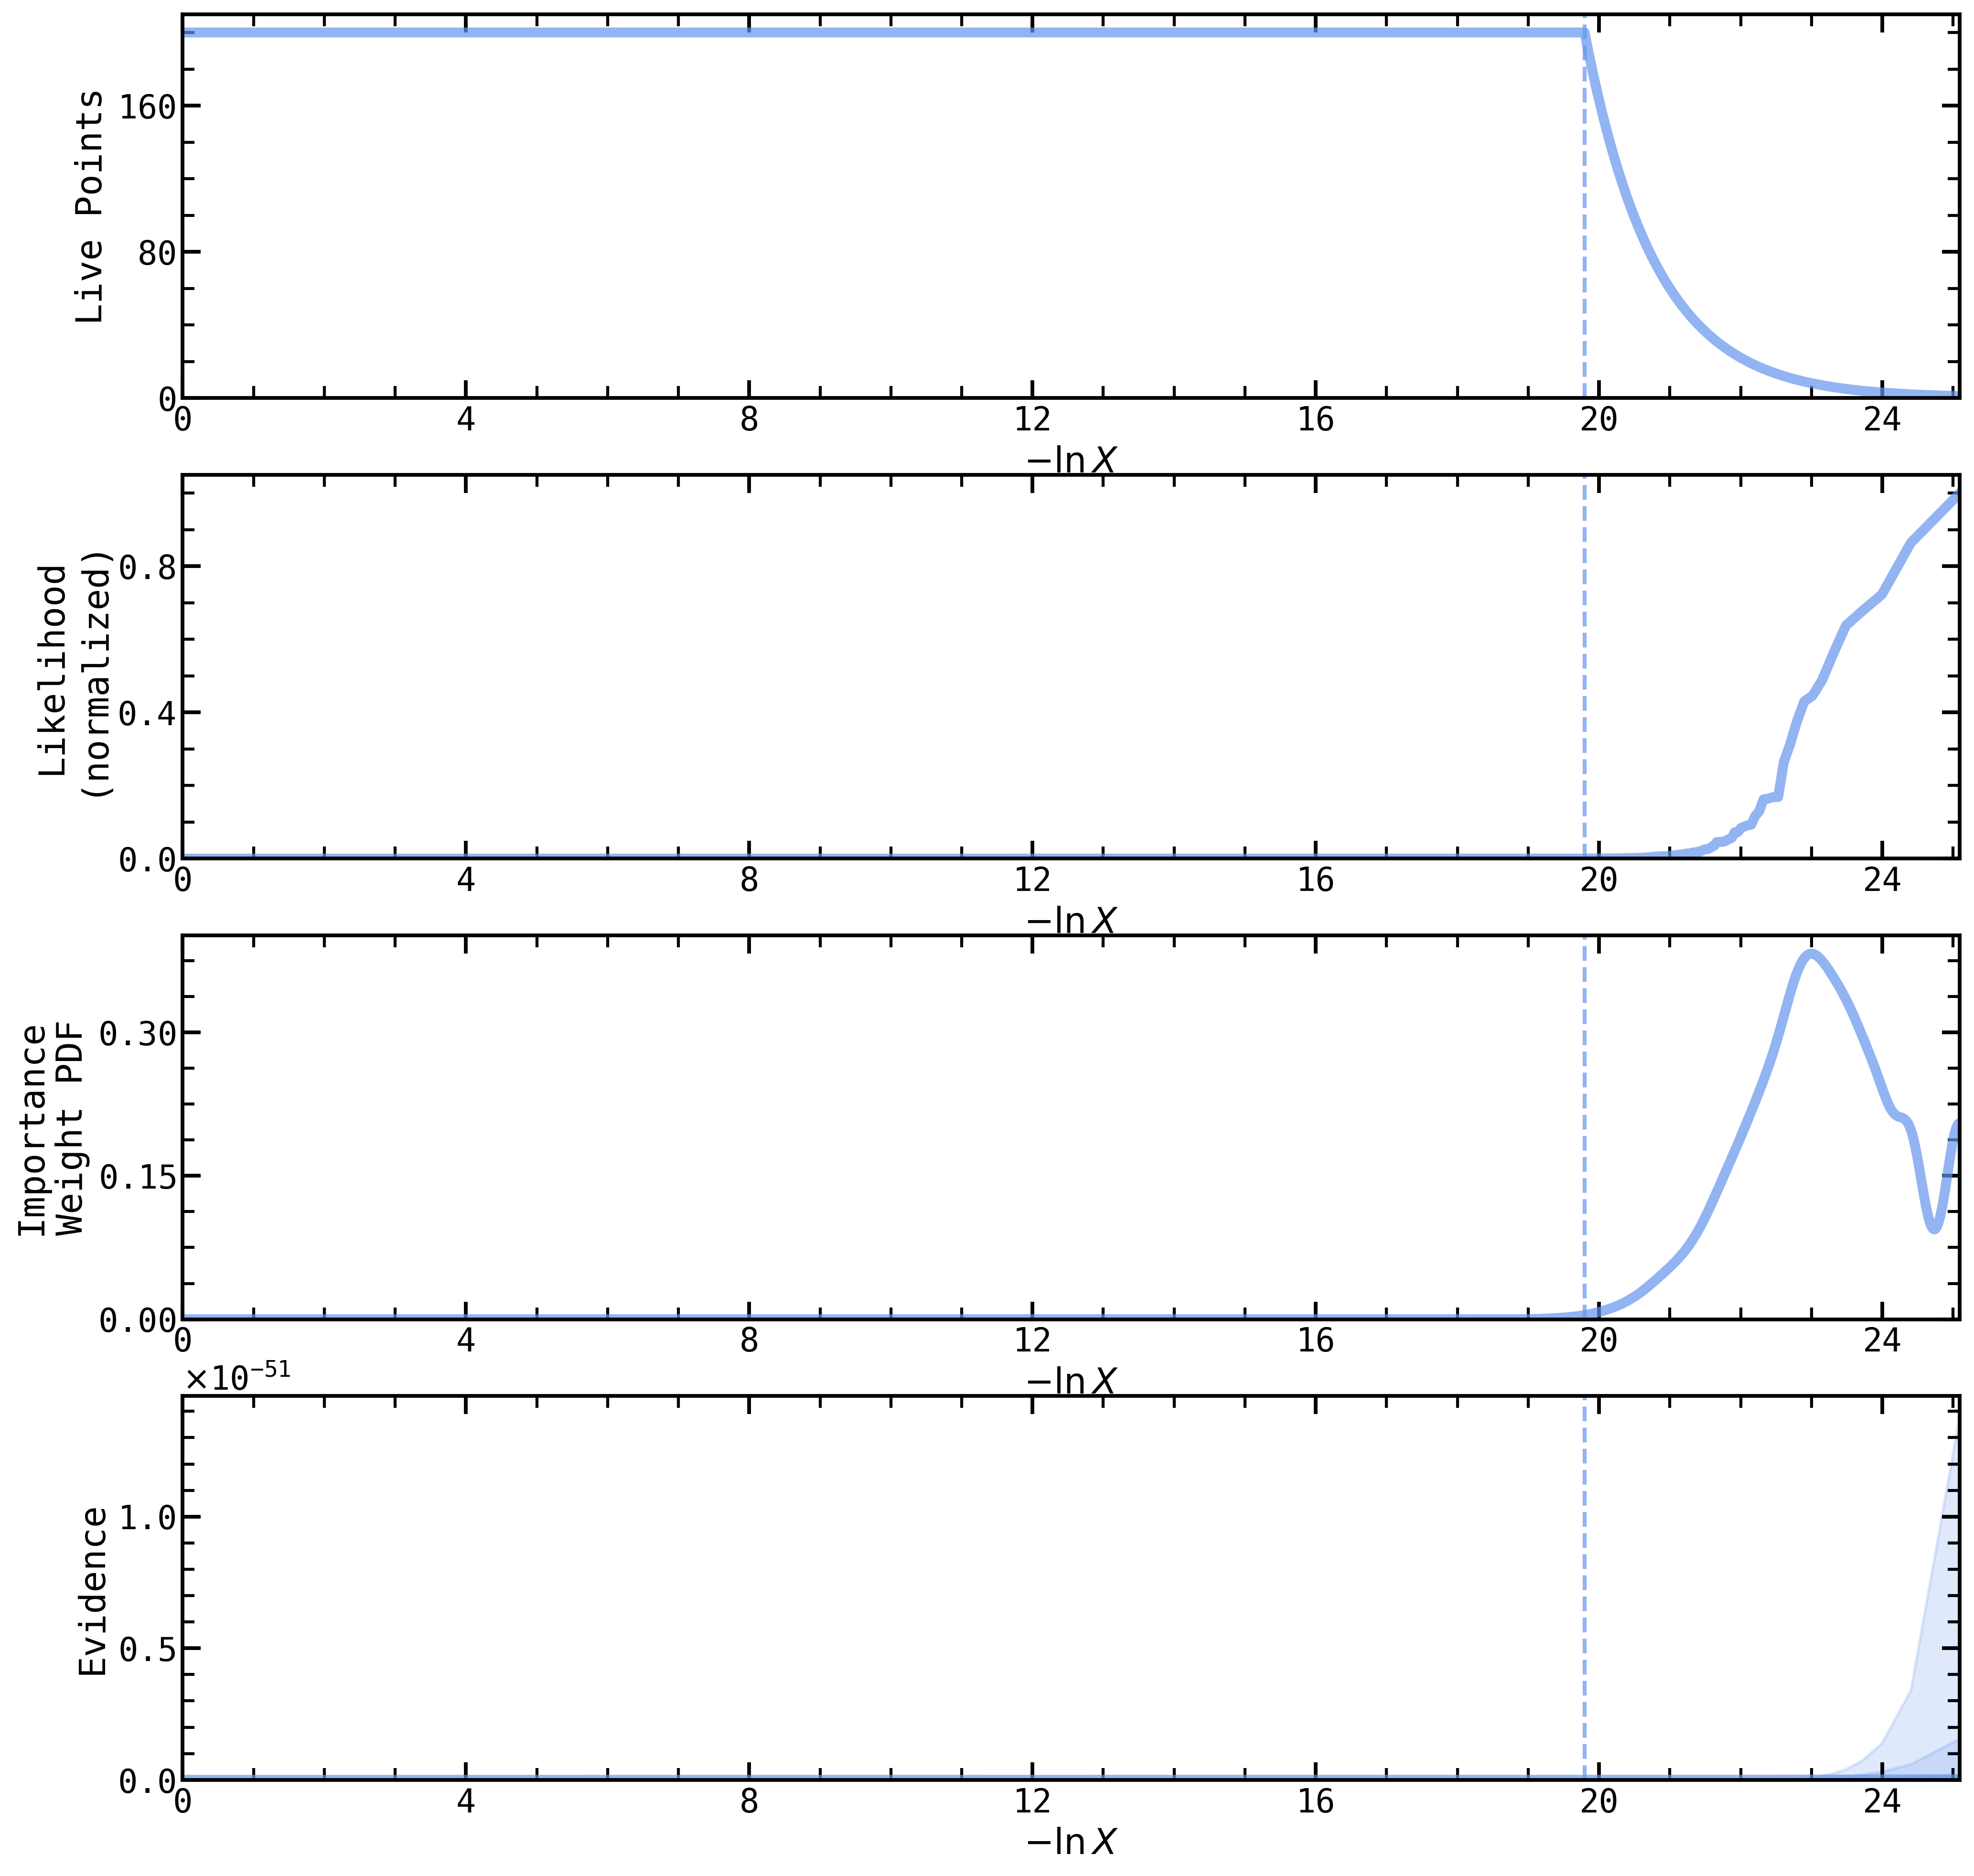

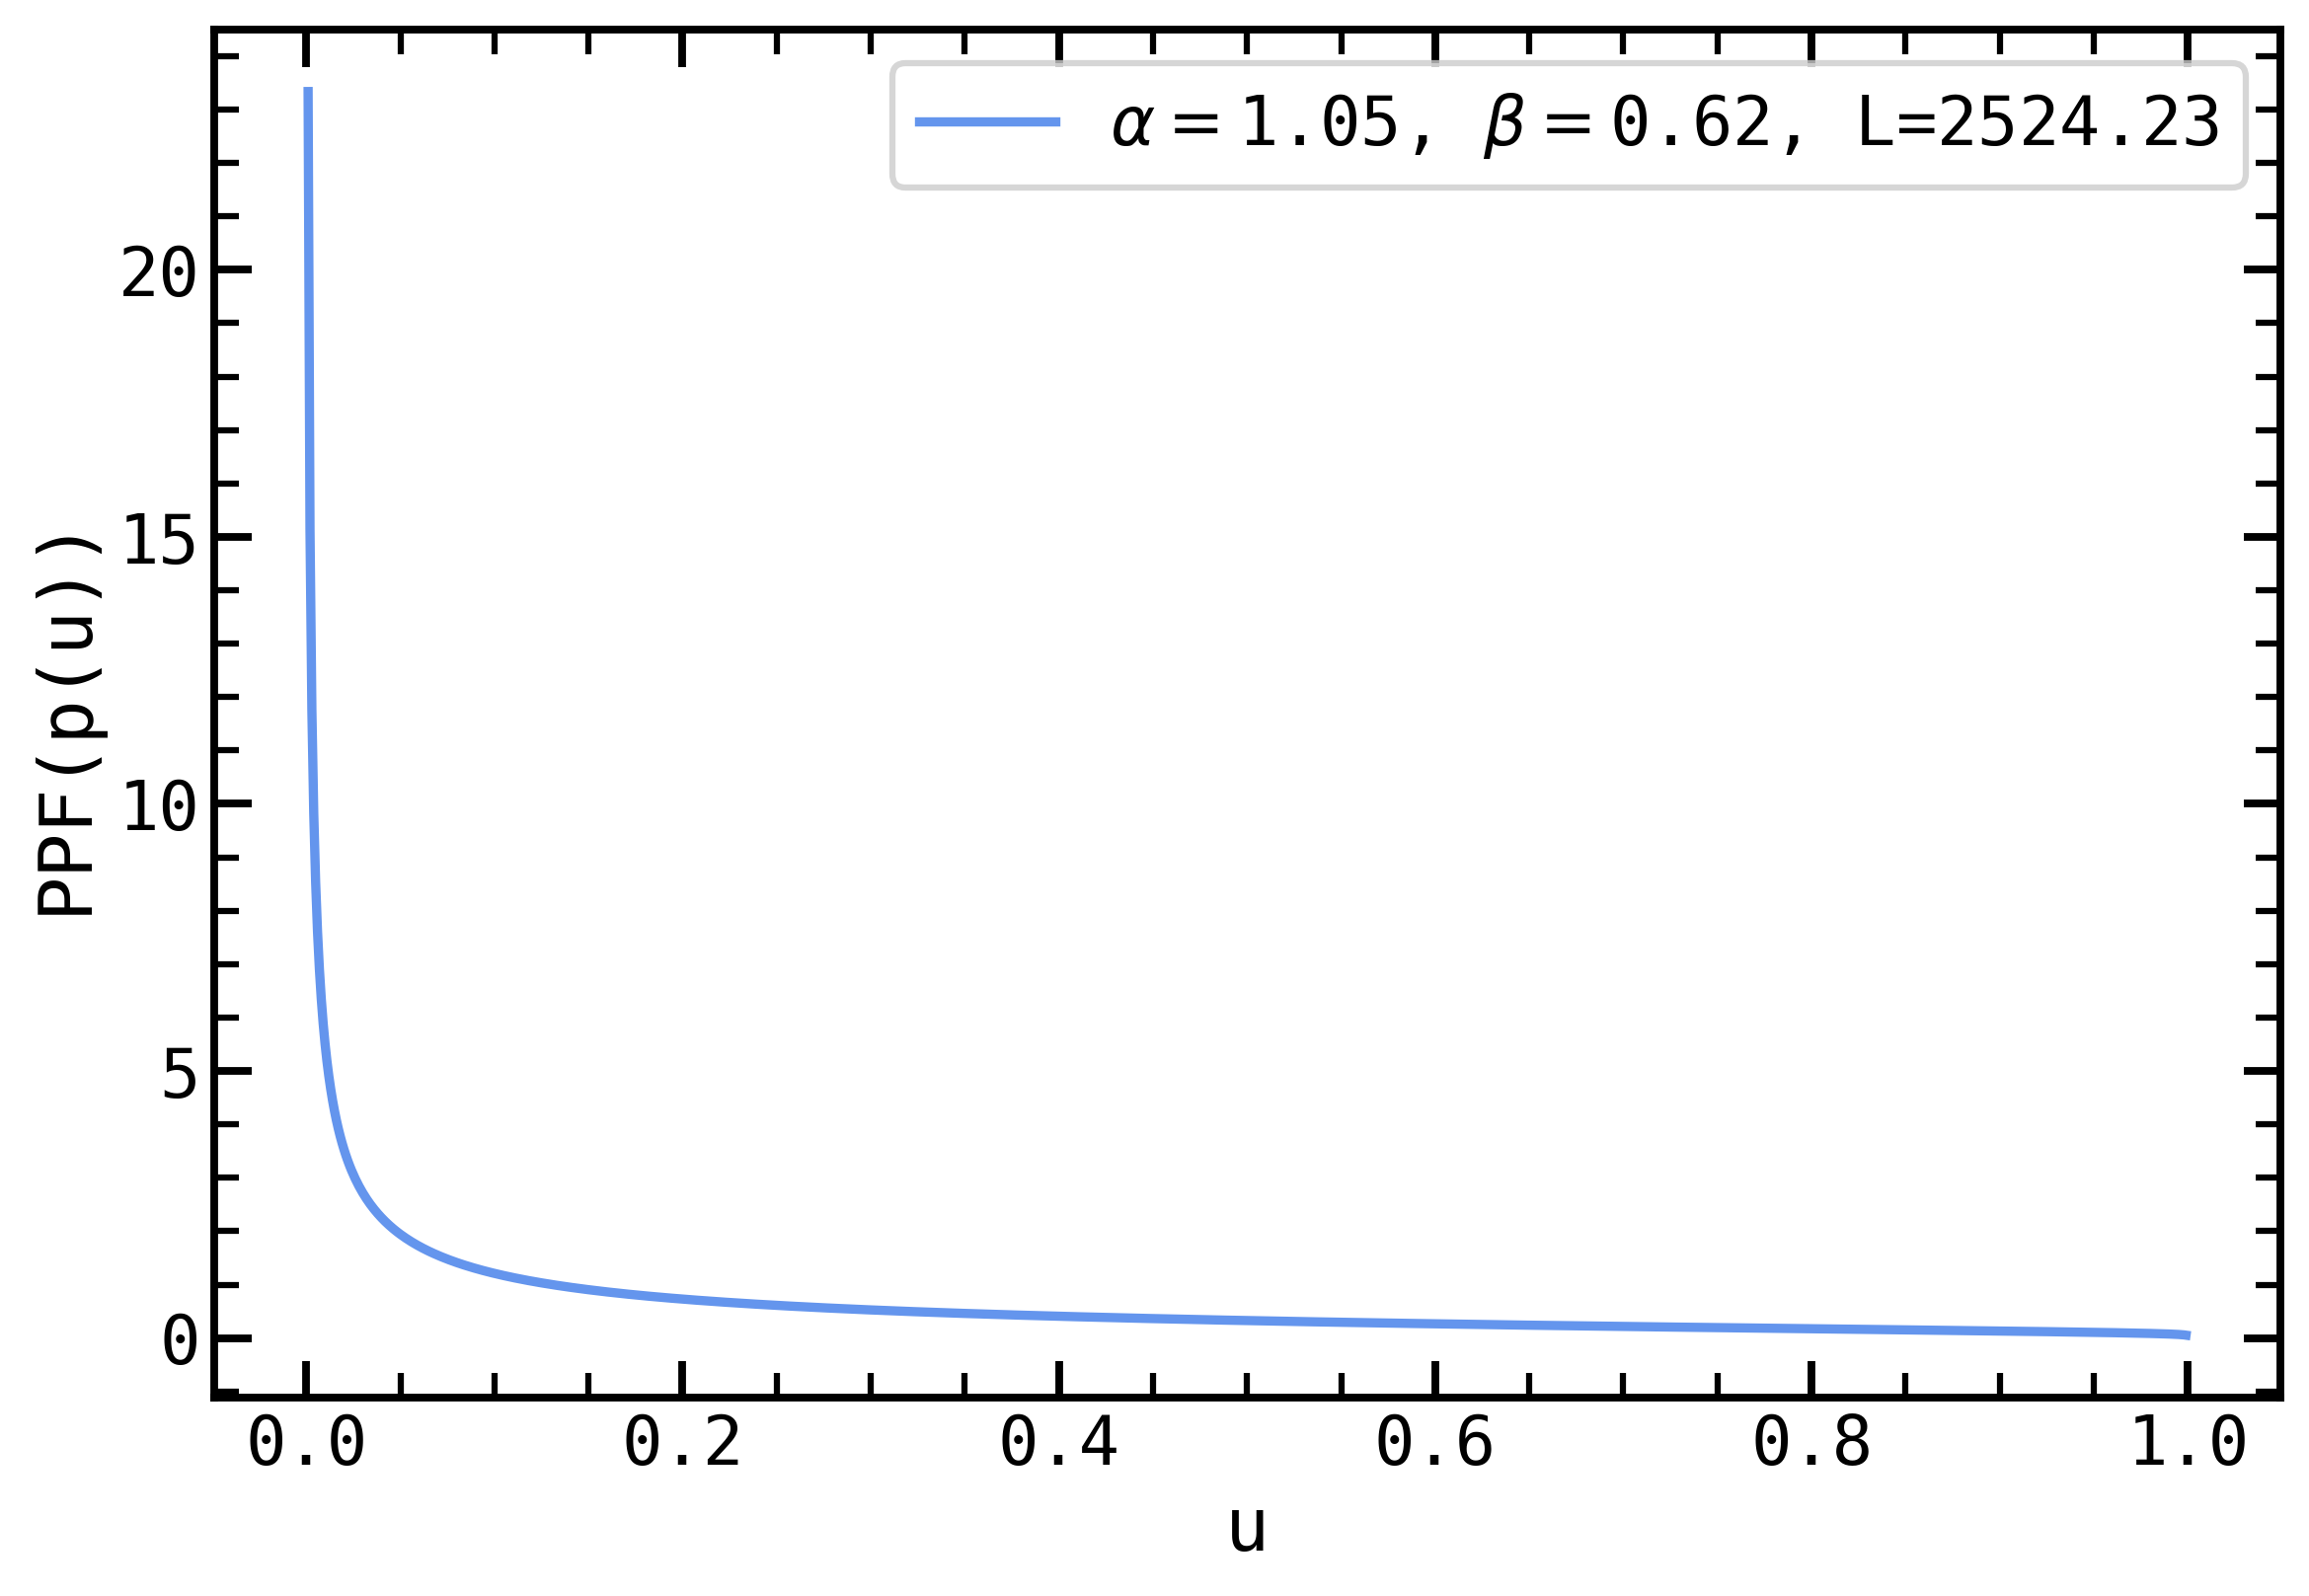

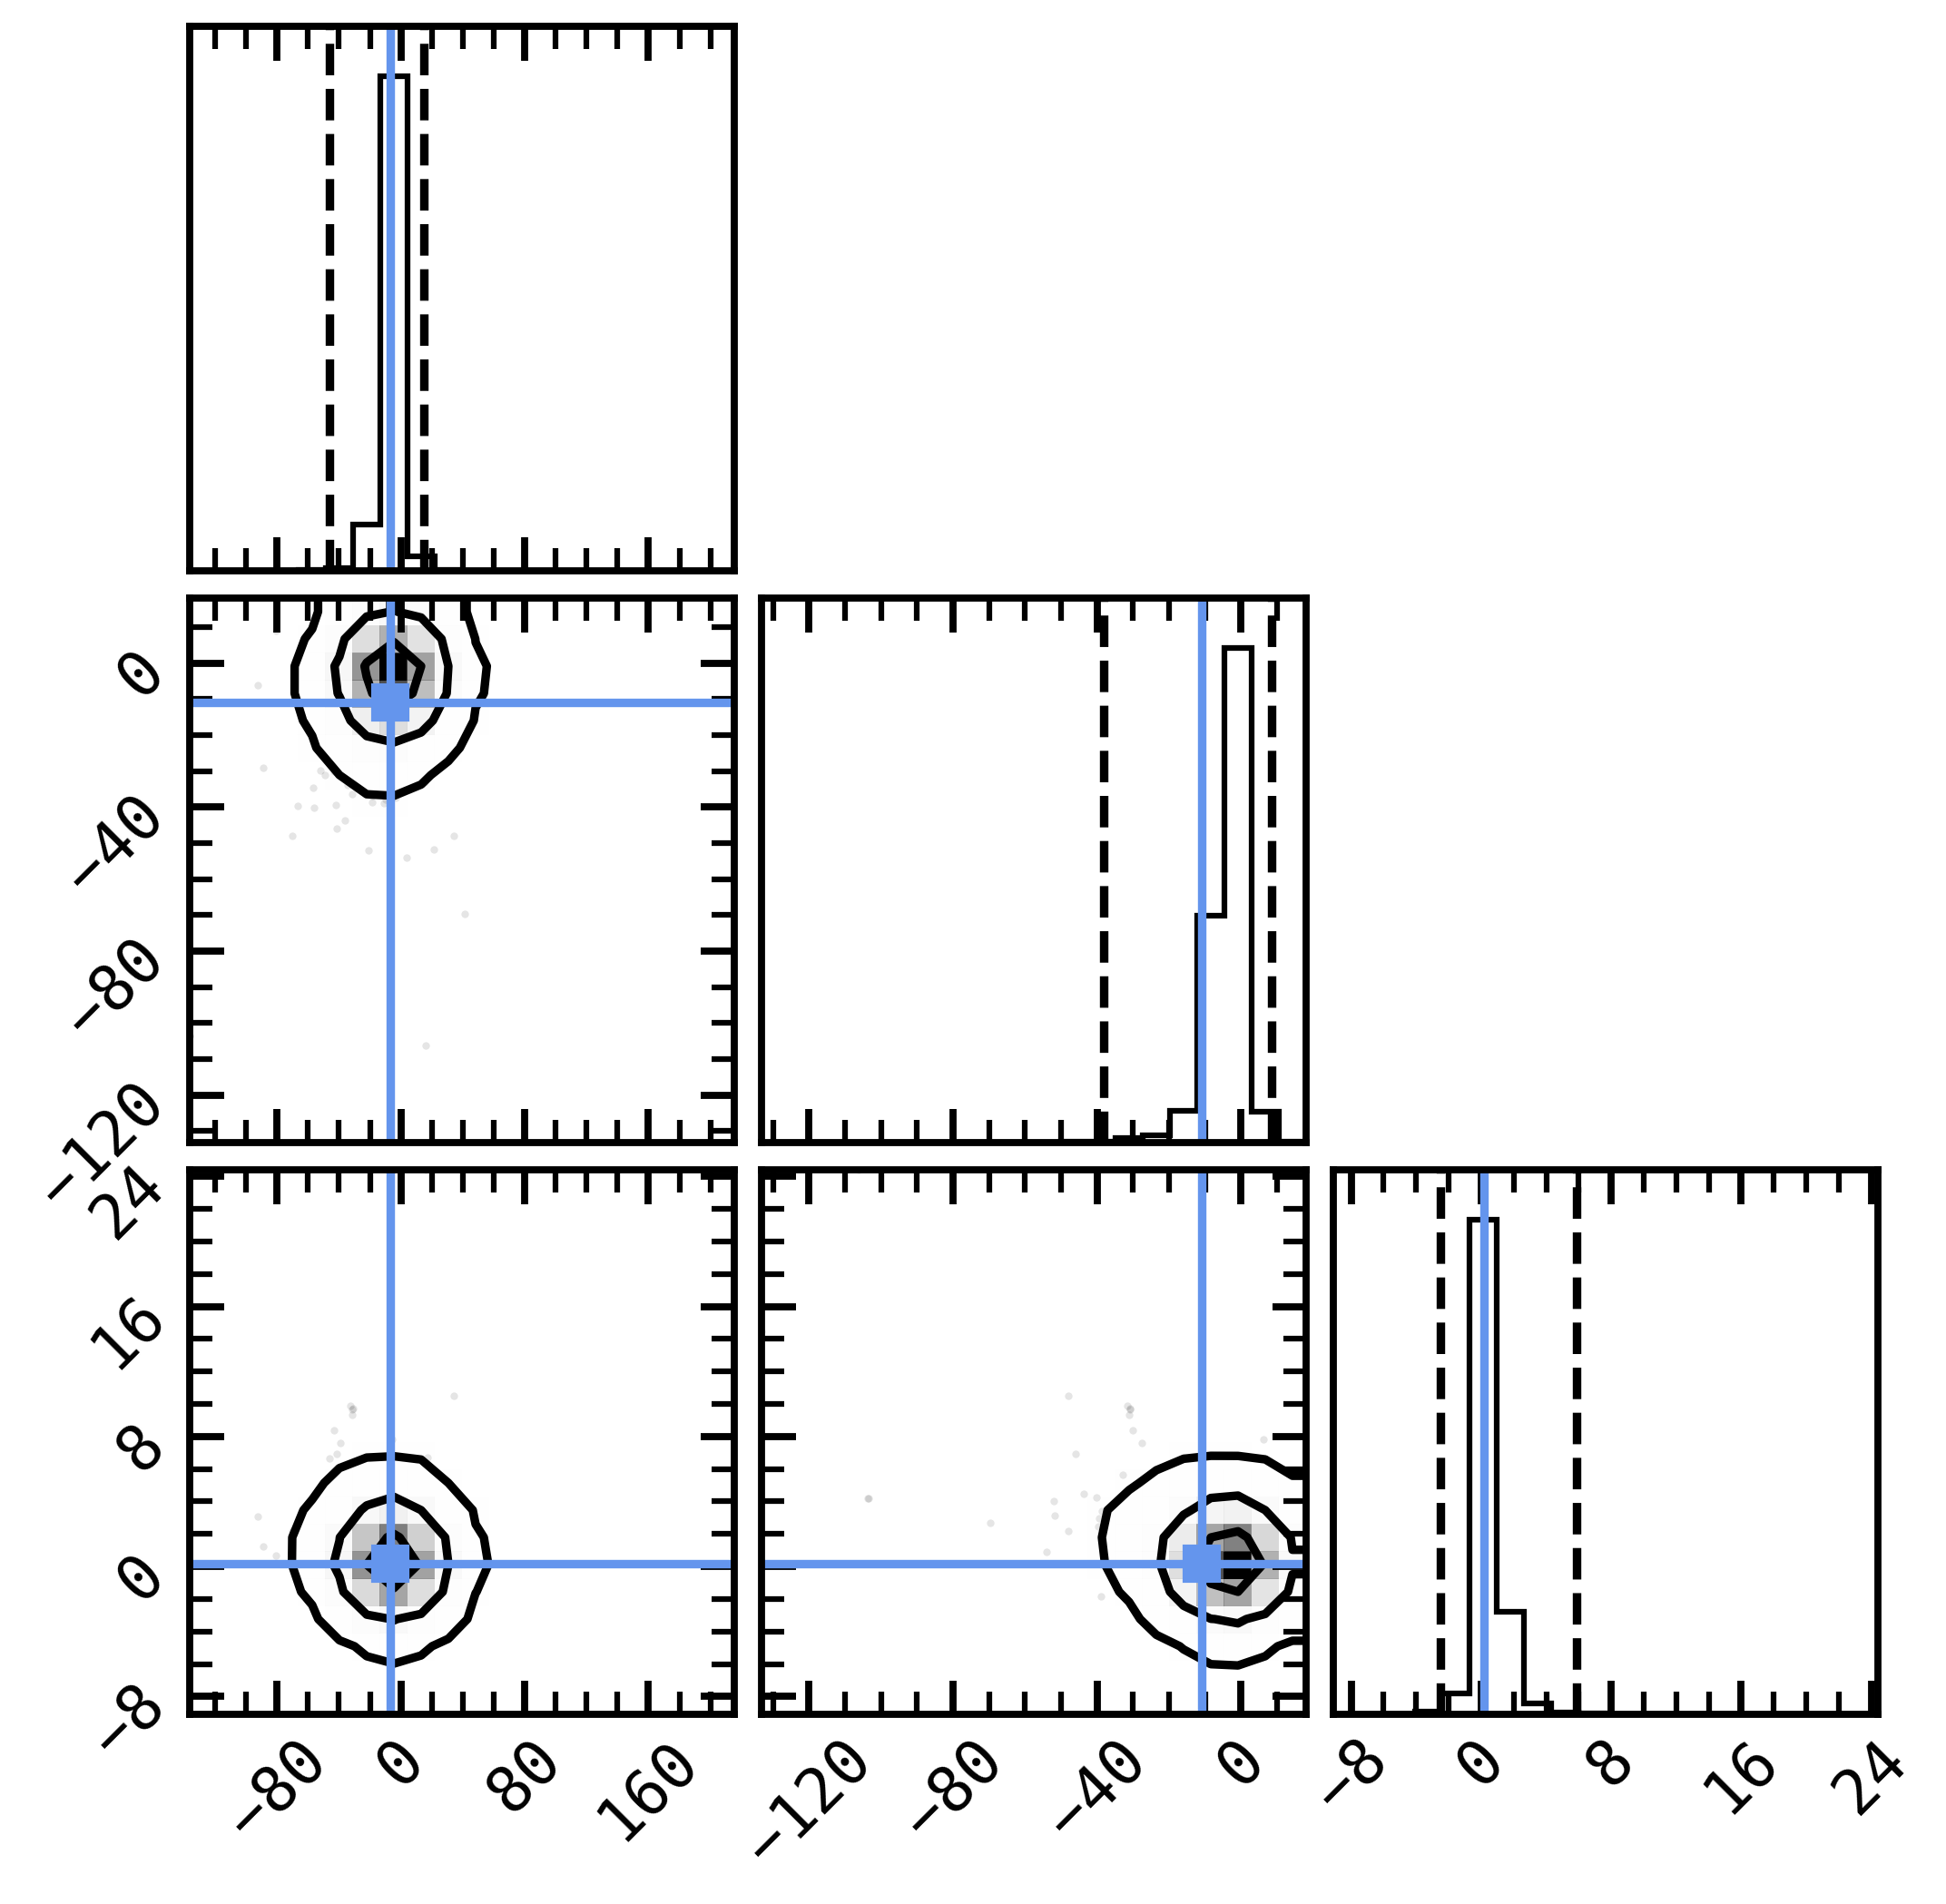

In [9]:
fig_track, fig_post, fig_diag, fig_prior, fig_hood = \
    track.generate_plots(days_backward=1.*365.,
                         days_forward=4.*365,
                         step_size=10.,
                         plot_radec=False,
                         plot_stationary=True,
                         fileprefix='./',
                         filepost='.png')

Unfortunately for HD131339 Ab, it looks like the data is well fit by a distant, quickly moving background star (as it turns out, the candidate's spectral energy distribution is also well fit by stellar spectral types). We've just reproduced a key result of [Nielsen et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017AJ....154..218N/abstract)'s argument (see their figure 18). Our posterior distribution looks a little hairy, so we'd probably want to increase our number of live points (or use dynamic nested sampling) to fully sample the posterior and be sure of our final result.

## What next?

Depending on the result of `backtracks.System.fit`, you could compare the goodness of fit between the median of this posterior distribution of background star cases to that of a bound, planetary orbit to decide whether your candidate is a planet or not. You can access the samples, or the median sample, from the `System` object via `System.results.samples`, and report the goodness of fit with `System.median_chi2_red`. 

In the case where there is little curvature in your data, and `backtracks.System.fit` reproduces effectively linear motion with the same parallax as the host, that's pretty good evidence that you have a bound body (a planet!) on your hands. We'd recommend using `orbitize!` or another orbit fitting package to assess this case, and compare to your `backtracks` results. If the motion is poorly fit by both a bound orbit and a moving, finite distance background track, then something even weirder might be going on.

Feel free to reach out to the developers (William, Gilles, and Tomas) if you run into any trouble using the code, or if you'd like advice on any particular use cases.